Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

--------------------------------------------------------------------------------
 >>> Starting LOSO (count-only, K-auto)
--------------------------------------------------------------------------------
Fold  1 | Test: subject1 | MAE: 4.15 | [Pred: 24.2 / GT: 20]
Fold  2 | Test: subject2 | MAE: 2.50 | [Pred: 19.5 / GT: 22]
Fold  3 | Test: subject3 | MAE: 1.50 | [Pred: 19.5 / GT: 21]
Fold  4 | Test: subject4 | MAE: 2.05 | [Pred: 19.0 / GT: 21]
Fold  5 | Test: subject5 | MAE: 2.98 | [Pred: 17.0 / GT: 20]
Fold  6 | Test: subject6 | MAE: 0.58 | [Pred: 21.6 / GT: 21]
Fold  7 | Test: subject7 | MAE: 1.60 | [Pred: 20.6 / GT: 19]
Fold  8 | Test: subject8 | MAE: 0.33 | [Pred: 20.3 / GT: 20]
Fold  9 | Test: subject9 | MAE: 1.49 | [Pred: 21.5 / GT: 20]
Fold 10 | Test: subject10 | MAE: 0.98 | [Pred: 21.0 / GT: 20]
--------------------------------------------------------------------------------
 

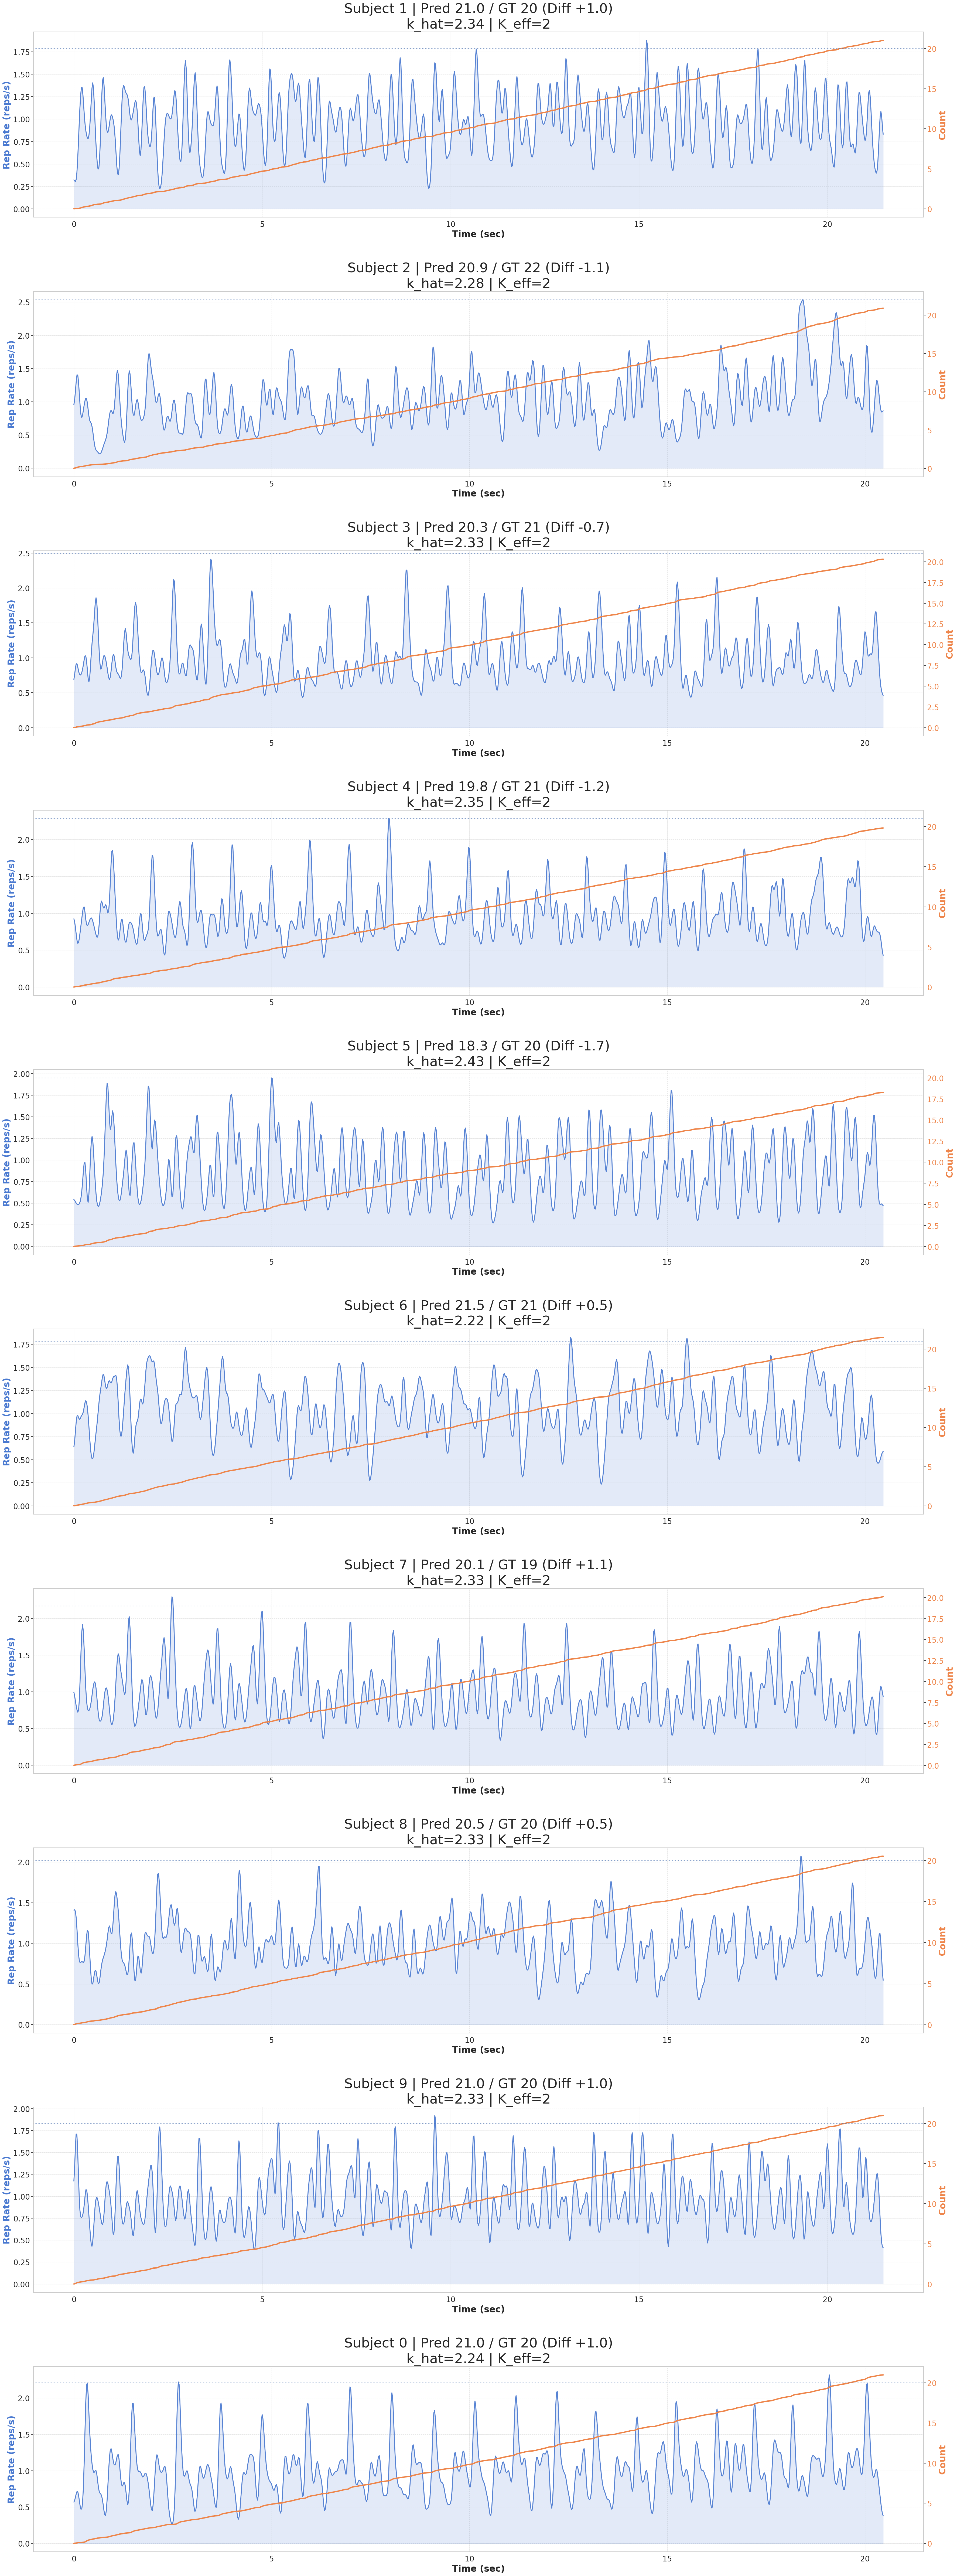

In [1]:
# =========================
# ✅ Count-only K-auto (Multi-event) version  (NO manual Pair/lag/overlap/balance)
#
# 핵심 아이디어
# - 모델이 K_max개의 "micro-event rate" r_k(t)를 예측 (k=1..K_max)
# - 샘플마다 "rep당 micro-event 개수" k_hat(>=1)을 스스로 추정
# - 우리가 주는 감독은 오직 rep count(=20) -> rep rate만 맞추게
#
# 수식 관점(코드 그대로):
#   micro_rate(t) = sum_k r_k(t)
#   rep_rate(t)   = micro_rate(t) / k_hat
#   pred_rep_rate = mean_t rep_rate(t)
#   loss_rate     = MSE(pred_rep_rate, GT_rep_rate)
#
# 규제(치팅 방지 / 일반적 prior)
# - sparse loss: 불필요한 stream을 꺼라 (L1 느낌)
# - k_reg loss : k_hat이 쓸데없이 커져서 도망치지 않게(아주 약하게)
# - smooth loss: rate가 너무 들쭉날쭉하지 않게(일반 prior)
# - recon loss : representation 안정화(옵션)
# =========================

import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ---------------------------------------------------------------------
# 1) Strict Seeding
# ---------------------------------------------------------------------
def set_strict_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# 2) Data Loading
# ---------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Z-score 정규화 (표준화) 평균=0, std=1
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,
                'count': float(gt_count),
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),         # (B, C, T_max)
        "mask": torch.stack(masks),               # (B, T_max)
        "count": torch.stack(counts),             # (B,)
        "length": torch.tensor(lengths, dtype=torch.float32),  # (B,)
        "meta": metas
    }


# ---------------------------------------------------------------------
# 3) Model
# ---------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        # x: (B, C, T)
        z = self.net(x)            # (B, D, T)
        z = z.transpose(1, 2)      # (B, T, D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        # z: (B, T, D)
        zt = z.transpose(1, 2)     # (B, D, T)
        x_hat = self.net(zt)       # (B, C, T)
        return x_hat


class MultiRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64, K_max=6):
        super().__init__()
        self.K_max = K_max
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1 + K_max)  # [amp_logit | phase_logits...]
        )

    def forward(self, z, tau=1.0):
        # z: (B,T,D)
        out = self.net(z)                     # (B,T,1+K)
        amp = F.softplus(out[..., 0])         # (B,T) >=0  (total micro intensity)
        phase_logits = out[..., 1:]           # (B,T,K)
        phase = F.softmax(phase_logits / tau, dim=-1)  # (B,T,K), sum=1
        return amp, phase, phase_logits


class KAutoCountModel(nn.Module):
    """
    - outputs K_max micro-event rates r_k(t)
    - predicts k_hat (>=1) per sample
    - rep_rate(t) = sum_k r_k(t) (모든 micro-event 합) / k_hat
    """
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, K_max=6, k_hidden=64):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = MultiRateHead(latent_dim, hidden=hidden_dim, K_max=K_max)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        with torch.no_grad():
            b = self.rate_head.net[-1].bias
            b.zero_()
            b[0].fill_(-2.0)  # amp logit bias만 -2

    @staticmethod
    def _pool_z(z, mask=None, eps=1e-6):
        # z: (B,T,D), mask: (B,T)
        if mask is None:
            return z.mean(dim=1)
        m = mask.to(dtype=z.dtype, device=z.device).unsqueeze(-1)  # (B,T,1)
        return (z * m).sum(dim=1) / (m.sum(dim=1) + eps)

    @staticmethod
    def _masked_mean_time(x, mask=None, eps=1e-6):
        # x: (B,T) or (B,T,K)
        if mask is None:
            return x.mean(dim=1)
        if x.dim() == 2:
            m = mask.to(dtype=x.dtype, device=x.device)            # (B,T)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)       # (B,)
        elif x.dim() == 3:
            m = mask.to(dtype=x.dtype, device=x.device).unsqueeze(-1)  # (B,T,1)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)           # (B,K)
        else:
            raise ValueError(f"Unsupported dim for masked mean: {x.dim()}")

    def forward(self, x, mask=None, tau=1.0):
        """
        x: (B,C,T), mask: (B,T)
        return:
          avg_rep_rate: (B,)
        """
        z = self.encoder(x)              # (B,T,D)
        x_hat = self.decoder(z)          # (B,C,T)

        amp_t, phase_p, phase_logits = self.rate_head(z, tau=1.0)
        rates_k_t = amp_t.unsqueeze(-1) * phase_p

        # micro-event sum
        micro_rate_t = amp_t


        p_bar = self._masked_mean_time(phase_p, mask)           # (B,K)
        k_hat = 1.0 / (p_bar.pow(2).sum(dim=1) + 1e-6)          # (B,) in [1,K]

        # rep rate
        rep_rate_t = micro_rate_t / (k_hat.unsqueeze(1) + 1e-6)    # (B,T)
        if mask is not None:
            rep_rate_t = rep_rate_t * mask

        # avg rep rate (masked mean)
        if mask is None:
            avg_rep_rate = rep_rate_t.mean(dim=1)
        else:
            avg_rep_rate = (rep_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "rates_k_t": rates_k_t,          # (B,T,K)
            "phase_p": phase_p,              # (B,T,K)
            "phase_logits": phase_logits,    # (B,T,K)
            "micro_rate_t": micro_rate_t,    # (B,T)
            "rep_rate_t": rep_rate_t,        # (B,T)
            "k_hat": k_hat,                  # (B,)
        }
        return avg_rep_rate, z, x_hat, aux


# ---------------------------------------------------------------------
# 4) Loss utils
# ---------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)              # (B,1,T)
    se = (x_hat - x) ** 2                    # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps  # valid(B*T)*C
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    """
    v: (B,T) -> L1 smoothness on first difference
    """
    dv = torch.abs(v[:, 1:] - v[:, :-1])  # (B,T-1)
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def phase_entropy_loss(phase_p, mask=None, eps=1e-8):
    """
    time-wise exclusivity: 각 t에서 phase가 one-hot에 가까워지게(entropy 최소화)
    phase_p: (B,T,K)
    """
    ent = -(phase_p * (phase_p + eps).log()).sum(dim=-1)  # (B,T)
    if mask is None:
        return ent.mean()
    ent = ent * mask
    return ent.sum() / (mask.sum() + eps)


def effK_usage_loss(phase_p, mask=None, eps=1e-6):
    """
    overall usage sparsity: time-avg phase usage의 effective-K를 줄이게
    effK = 1 / sum(p_bar^2)  in [1,K]
    """
    if mask is None:
        p_bar = phase_p.mean(dim=1)  # (B,K)
    else:
        m = mask.to(dtype=phase_p.dtype, device=phase_p.device).unsqueeze(-1)  # (B,T,1)
        p_bar = (phase_p * m).sum(dim=1) / (m.sum(dim=1) + eps)

    effK = 1.0 / (p_bar.pow(2).sum(dim=1) + eps)
    return effK.mean(), effK.detach()


# ---------------------------------------------------------------------
# 5) Train
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    stats = {k: 0.0 for k in [
        'loss', 'loss_rate', 'loss_recon', 'loss_smooth', 'loss_phase_ent', 'loss_effk',
        'mae_count'
    ]}

    fs = config["fs"]
    tau = config.get("tau", 1.0)

    lam_recon = config.get("lambda_recon", 1.0)
    lam_smooth = config.get("lambda_smooth", 0.05)
    lam_phase_ent = config.get("lambda_phase_ent", 0.01)
    lam_effk = config.get("lambda_effk", 0.005)

    for batch in loader:
        x = batch["data"].to(device)         # (B,C,T)
        mask = batch["mask"].to(device)      # (B,T)
        y_count = batch["count"].to(device)  # (B,)
        length = batch["length"].to(device)  # (B,)

        duration = torch.clamp(length / fs, min=1e-6)  # sec
        y_rate = y_count / duration                    # reps/s

        optimizer.zero_grad()

        rate_hat, z, x_hat, aux = model(x, mask, tau=tau)

        # (1) 속도 맞추기 (MSE Loss)
        loss_rate = F.mse_loss(rate_hat, y_rate)

        # (2) recon
        loss_recon = masked_recon_mse(x_hat, x, mask)

        # (3) smoothness (rep_rate_t 기준)
        loss_smooth = temporal_smoothness(aux["rep_rate_t"], mask)

        # (4) phase exclusivity (entropy)
        loss_phase_ent = phase_entropy_loss(aux["phase_p"], mask)

        # (5) effective-K usage (overall)
        loss_effk, _ = effK_usage_loss(aux["phase_p"], mask)

        loss = (loss_rate
                + lam_recon * loss_recon
                + lam_smooth * loss_smooth
                + lam_phase_ent * loss_phase_ent
                + lam_effk * loss_effk)

        loss.backward()
        optimizer.step()

        # MAE on count
        count_hat = rate_hat * duration  # 예측 속도 * 시간 = 예측 개수
        stats['loss'] += loss.item()
        stats['loss_rate'] += loss_rate.item()
        stats['loss_recon'] += loss_recon.item()
        stats['loss_smooth'] += loss_smooth.item()
        stats['loss_phase_ent'] += loss_phase_ent.item()
        stats['loss_effk'] += loss_effk.item()
        stats['mae_count'] += torch.abs(count_hat - y_count).mean().item()

    n = len(loader)
    return {k: v / n for k, v in stats.items()}


# ---------------------------------------------------------------------
# 6) Visualization helpers (subject-wise subplot)
# ---------------------------------------------------------------------
def _smooth_1d(y, sigma=2.0):
    """
    지저분한 노이즈를 다듬어서 시각화
    """
    y = np.asarray(y, dtype=np.float32)
    return gaussian_filter1d(y, sigma=sigma)


def compute_K_eff(use_k, rel_th=0.2):
    """
    use_k: (K,) stream usage (mean rate)
    rel_th: max 대비 몇 % 이상을 '활성'으로 볼지
    """
    use_k = np.asarray(use_k, dtype=np.float32)
    mx = float(use_k.max()) if use_k.size else 0.0
    if mx <= 1e-8:
        return 0
    return int(np.sum(use_k >= (rel_th * mx)))


def visualize_all_subjects(model, full_data, config, device):
    """
    - 10 subjects를 subplot(grid)으로 "rep_rate(t) & cumulative count"만 깔끔히 보여줌
    - 각 subject별 k_hat, K_eff도 같이 출력
    """
    sns.set_theme(style="whitegrid", context="notebook", font_scale=2.0)
    colors = sns.color_palette("muted")
    c_rate = colors[0]   # 파란색 (속도)
    c_count = colors[1]  # 주황색 (누적 개수)
    c_gt = "gray"        # 회색 (정답 라벨)

    subject_list = [f"subject{i}" for i in range(1, 11)]
    gt_map = {item[0]: float(item[2]) for item in config["ALL_LABELS"]}

    target_act_id = 12
    act_name = config["TARGET_ACTIVITIES_MAP"][target_act_id]
    feats = config["ACT_FEATURE_MAP"][target_act_id]

    fs = config["fs"]
    tau = config.get("tau", 1.0)

    fig, axes = plt.subplots(10, 1, figsize=(36, 96), sharex=False)
    axes = axes.flatten()

    print()
    print(f" {'Subject':<10} | {'GT':>4} | {'Pred':>6} | {'Diff':>7} | {'k_hat':>5} | {'K_eff':>5} | {'Stream Usage (use_k)'}")
    print("-"*80)

    rows = []

    for i, subj_id in enumerate(subject_list):
        ax = axes[i]

        if subj_id not in full_data or act_name not in full_data[subj_id]:
            ax.set_title(f"{subj_id} (missing)", fontsize=30)
            ax.axis("off")
            continue

        # 데이터 준비
        raw_df = full_data[subj_id][act_name][feats]
        raw_np = raw_df.values.astype(np.float32)
        mean = raw_np.mean(axis=0)
        std = raw_np.std(axis=0) + 1e-6
        norm_np = (raw_np - mean) / std

        # 모델 예측
        model.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(norm_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
            rate_hat, _, _, aux = model(x_tensor, mask=None)

            rates_k = aux["rates_k_t"].squeeze(0).cpu().numpy()     # (T,K)
            rep_rate = aux["rep_rate_t"].squeeze(0).cpu().numpy()   # (T,)
            k_hat = float(aux["k_hat"].item())

        T = rep_rate.shape[0]
        t = np.arange(T) / fs

        # Metrics 계산
        use_k = rates_k.mean(axis=0)  # (K,)
        K_eff = compute_K_eff(use_k, rel_th=0.2)

        duration = T / fs
        pred_count = float(rate_hat.item() * duration)
        gt_count = float(gt_map.get(subj_id, 0.0))

        # numpy array를 깔끔한 문자열로 변환
        diff = pred_count - gt_count
        use_k_str = np.array2string(use_k, formatter={'float_kind':lambda x: "%.2f" % x}, separator=', ')

        # 데이터 가공 (Smoothing)
        rep_s = _smooth_1d(rep_rate, sigma=2.0)
        cum = np.cumsum(rep_rate) / fs

        # 속도 (Rep Rate) - 파란색 영역 채우기
        ax.plot(t, rep_s, color=c_rate, linewidth=2.5, alpha=0.9, label="Rate (Speed)")
        ax.fill_between(t, rep_s, color=c_rate, alpha=0.15)
        ax.set_ylabel("Rep Rate (reps/s)", color=c_rate, fontweight='bold', fontsize=24)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=20)

        # 누적 개수 (Cumulative Count) - 주황색 실선
        ax2 = ax.twinx()
        ax2.plot(t, cum, color=c_count, linewidth=3.5, alpha=1.0, label="Cumulative Count")
        ax2.axhline(gt_count, linestyle=":", alpha=0.7)

        ax2.set_ylabel("Count", color=c_count, fontweight='bold', fontsize=24)
        ax2.tick_params(axis='y', labelcolor=c_count, labelsize=20)
        ax2.grid(False) # 오른쪽 축 그리드는 끄기

        ax.set_title(
            f"Subject {subj_id[-1:]} | Pred {pred_count:.1f} / GT {gt_count:.0f} (Diff {diff:+.1f})\n"
            f"k_hat={k_hat:.2f} | K_eff={K_eff}",
            fontsize=36, pad=10)
        ax.set_xlabel("Time (sec)", fontweight='bold', fontsize=24)

        print(f" {subj_id:<10} | {gt_count:>4.0f} | {pred_count:>6.2f} | {diff:>+7.2f} | {k_hat:>5.2f} | {K_eff:>5d} | {use_k_str}")

        rows.append((subj_id, gt_count, pred_count, pred_count-gt_count, k_hat, K_eff, use_k))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

    return rows


# ---------------------------------------------------------------------
# 7) Main (LOSO)
# ---------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            6: 'Waist bends forward',
            7: 'Frontal elevation of arms',
            8: 'Knees bending',
            12: 'Jump front & back'
        },
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z'],
            7: ['acc_arm_x', 'acc_arm_y', 'acc_arm_z', 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'],
            8: ['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z'],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,

        # Model
        "hidden_dim": 128,
        "latent_dim": 16,
        "K_max": 6,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_smooth": 0.05,
        "lambda_phase_ent": 0.01,
        "lambda_effk": 0.005,

        # temperature (phase 경쟁 강도)
        "tau": 1.0,

        # Count-only labels (rep 기준)
        # ※ mHealth의 "Jump front & back"이 rep=20이라면 20으로 두는 게 맞음.
        "ALL_LABELS": [
            ("subject1", 12, 20),
            ("subject2", 12, 22),
            ("subject3", 12, 21),
            ("subject4", 12, 21),
            ("subject5", 12, 20),
            ("subject6", 12, 21),
            ("subject7", 12, 19),
            ("subject8", 12, 20),
            ("subject9", 12, 20),
            ("subject10", 12, 20),
        ],
    }

    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]
    loso_results = []

    print("\n" + "-"*80)
    print(" >>> Starting LOSO (count-only, K-auto)")
    print("-"*80)

    last_trained_model = None

    for fold_idx, test_subj in enumerate(subjects):
        set_strict_seed(CONFIG["seed"])

        train_labels = [x for x in CONFIG["ALL_LABELS"] if x[0] != test_subj]
        test_labels  = [x for x in CONFIG["ALL_LABELS"] if x[0] == test_subj]

        train_data = prepare_trial_list(train_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
        test_data  = prepare_trial_list(test_labels,  full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])

        if not test_data:
            print(f"[Skip] Fold {fold_idx+1}: {test_subj} has no data.")
            continue

        g = torch.Generator()
        g.manual_seed(CONFIG["seed"])

        train_loader = DataLoader(
            TrialDataset(train_data),
            batch_size=CONFIG["batch_size"],
            shuffle=True,
            collate_fn=collate_variable_length,
            generator=g,
            num_workers=0
        )

        input_ch = train_data[0]['data'].shape[1]
        model = KAutoCountModel(
            input_ch=input_ch,
            hidden_dim=CONFIG["hidden_dim"],
            latent_dim=CONFIG["latent_dim"],
            K_max=CONFIG["K_max"]
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

        for epoch in range(CONFIG["epochs"]):
            stats = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
            scheduler.step()

        model.eval()
        last_trained_model = model

        # fold test
        fold_mae = 0.0
        fold_res_str = ""

        for item in test_data:
            with torch.no_grad():
                x_tensor = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                duration = x_tensor.shape[2] / CONFIG["fs"]

                rate_hat, _, _, aux = model(x_tensor, mask=None)
                count_pred = rate_hat.item() * duration # 모델이 예측한 속도(rate) * 시간(duration) = 예측 개수
                count_gt = float(item['count'])

                abs_err = abs(count_pred - count_gt)  # 실제 개수와의 차이 (절대오차)
                fold_mae += abs_err
                fold_res_str += f"[Pred: {count_pred:.1f} / GT: {count_gt:.0f}]"

        fold_mae /= len(test_data)
        loso_results.append(fold_mae)

        print(f"Fold {fold_idx+1:2d} | Test: {test_subj} | MAE: {fold_mae:.2f} | {fold_res_str}")

    print("-"*80)
    print(f" >>> Final LOSO Result (Average MAE): {np.mean(loso_results):.3f}")
    print(f" >>> Standard Deviation: {np.std(loso_results):.3f}")
    print("-"*80)

    # subject-wise subplot visualization (마지막 fold 학습 모델 기준)
    if last_trained_model is not None:
        visualize_all_subjects(last_trained_model, full_data, CONFIG, device)


if __name__ == "__main__":
    main()
